## Molecular orbital (MO)
We will get the energy of HOMO and LUMO. We will also visualize the MOs

Let us start by running a SCF calculation

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [4]:
smiles = "C=C"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(mol)
Chem.MolToXYZFile(mol, "Ethene.xyz")

In [5]:
from pyscf import gto, scf

In [6]:
mol = gto.M(atom = "Ethene.xyz")

mol.basis = "6-31G"
mf = mol.KS()
mf.xc = "b3lyp"
neutral_energy = mf.kernel()

converged SCF energy = -77.5597819144037


### Most electronic structure packages will give you HOMO and LUMO values. But here is how to get it manually

1. Get the total number of electrons (n)
2. HOMO is the n/2 orbital

In [7]:
n = mol.tot_electrons()
n

16

In [8]:
# display all the orbitals
mf.mo_energy

array([-9.98598228, -9.98571455, -0.7208095 , -0.53264935, -0.44389373,
       -0.36163251, -0.32052176, -0.21563197,  0.12567999,  0.4122534 ,
        0.41925549,  0.44575869,  0.67443787,  0.71077329])

In [9]:
# HOMO is n/2 orbital. But python index starts from 0
homo = mf.mo_energy[int(n/2)-1]
homo

-0.21563197106806037

In [10]:
# energy unit of cal is hartree, convert it to eV
homo * 27.2114

-5.867647817521418

#### MOs are regions of electron density. They can be visualized.

In [13]:
from pyscf.tools import molden

# write the surface to molden files

with open("Ethene.molden", 'w') as f1:
    molden.header(mol, f1)
    molden.orbital_coeff(mol, f1, mf.mo_coeff, ene = mf.mo_energy, occ = mf.mo_occ)
    
# these can be visualized with GUI softwares (Avogadro)

### Charged system
The systems we looked at were neutral. Let us run calculations for charged system

In [15]:
# Run single-point energy for cation of ethene

In [18]:
from pyscf import gto, scf

mol = gto.M(atom="Ethene.xyz")
mol.basis = "6-31G"

In [25]:
########## SET CHARGE ################
mol.charge = 1
mol.spin = 1  # this is for number of unpaired electron, 

In [26]:
mf = mol.KS()
mf.xc = 'b3lyp'
cation_energy = mf.kernel()

converged SCF energy = -77.2036932645881  <S^2> = 0.7514781  2S+1 = 2.0014776


#### Now that we have total energy of neutral molecule and cationic molecule, we can compute ionization energy

In [27]:
ionisation_energy = (neutral_energy - cation_energy) * 27.2114
ionisation_energy

-9.68967068559232

In [28]:
# for electron affinity
mol.charge = -1
mol.spin = 1
mf = mol.KS()
mf.xc = 'b3lyp'
anion_energy = mf.kernel()

converged SCF energy = -77.291709099659  <S^2> = 0.7517066  2S+1 = 2.0017059


In [33]:
# electron_affinity is the energy that we have to provide for an electron addition
electron_affinity = (-1)*(neutral_energy - anion_energy) * 27.2114
electron_affinity

7.294636591143115

## (Implicit modelling of) Solvent effects

Adding actual solvent molecules (explicit solvation) is computationally expensive. Implicit solvation uses dielectric constant to model polarization charges in molecule. PCM and COSMO are popular solvation models.

Here we will use COSMO as it is the model implemented in pySCF.

In [47]:
mol = gto.M(atom = "Ethene.xyz")
mol.basis = "6-31G"
mf = mol.KS()
mf.xc = "b3lyp"

In [48]:
# set solvent
mf = mf.DDCOSMO()
mf.with_solvent.eps = 35.688  # Acetonitrile

In [49]:
# run single point energy
mf = mf.run()

# Total Energy
neutral_energy_solvent = mf.e_tot

converged SCF energy = -77.5605507160989


In [51]:
# Solvent enthalpy
solvent_enthalpy = (neutral_energy - neutral_energy_solvent) * 27.2114
solvent_enthalpy

0.020920170449970535

## Time-dependent DFT (TD-DFT)
Behind the scene of TD-DFT is similar to DFT. We have basis set, functional, charge, spin etc. The difference in the equation we solve.

In DFT we solve time independent Kohn-Sham equation (similar to time independent Schrodinger equation). For TD-DFT we solve equation similar to time dependent Schrodinger equation

                                 H^Ψ(x,t)=iℏ*(∂/∂t)Ψ(x,t)

In [64]:
from pyscf import gto, scf, dft, tddft

In [72]:
mol = gto.M(atom = "Ethene.xyz")
mol.basis= "6-31G"
mf = dft.RKS(mol)
mf.xc = 'b3lyp'

# set solvent
mf = mf.DDCOSMO()
mf.with_solvent.eps = 35.688  # Acetonitrile
mf = mf.run()

converged SCF energy = -77.5605507160989


In [73]:
# setup the tddft
td = tddft.TDDFT(mf)

# set type and number of states required for a particular spin configuration
td.singlet = True
td.nstates = 10

# run TDDFT
td.kernel()

# analyze to show a table of excitations
td.analyze()

Excited State energies (eV)
[10.26790607 10.79627761 10.9847179  13.49573828 15.18372842 15.51866993
 16.64698156 17.96497441 19.31008608 19.38130701]

** Singlet excitation energies and oscillator strengths **
Excited State   1:     10.26791 eV    120.75 nm  f=0.0000
Excited State   2:     10.79628 eV    114.84 nm  f=0.4096
Excited State   3:     10.98472 eV    112.87 nm  f=0.0000
Excited State   4:     13.49574 eV     91.87 nm  f=0.0000
Excited State   5:     15.18373 eV     81.66 nm  f=0.0000
Excited State   6:     15.51867 eV     79.89 nm  f=0.0014
Excited State   7:     16.64698 eV     74.48 nm  f=0.0000
Excited State   8:     17.96497 eV     69.01 nm  f=0.4001
Excited State   9:     19.31009 eV     64.21 nm  f=0.3203
Excited State  10:     19.38131 eV     63.97 nm  f=0.1183


## helper function to plot absorption spectrum

In [78]:
def plot_absorption(td_obj, step = 0.01, sigma = 0.05):
    import scipy.constants as cst
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    
    # get transitions and convert them into eV
    
    transitions = td_obj.e * 27.2114
    
    # get oscillator strength
    f = td_obj.oscillator_strength()
    
    # get min and max x_values for plot
    min_val = min([val for val in transitions]) - 5.0 * sigma
    max_val = max([val for val in transitions]) + 0.5 * sigma
    
    # number of data points in line
    npts = int((max_val -min_val)/ step) + 1
    
    # geenrating the plot
    ene_val = np.linspace(min_val, max_val, npts)    # in eV
    lambda_val = [cst.h * cst.c / (val * cst.e) * 1.e9
                 for val in ene_val]                       # in nm
    
    # sum of gaussiamn fucntions
    spectra = np.zeros(npts)
    for i in range(len(transitions)):
        spectra += f[i] * norm.pdf(ene_val, transitions[i], sigma)
        
    spectra /= spectra.max()
    
    # plot the spectrum
    plt.plot(lambda_val , spectra)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorption (au)")

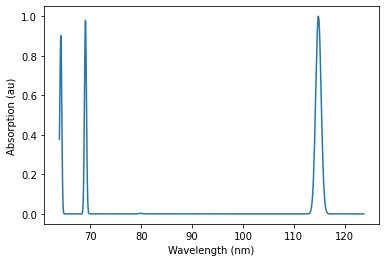

In [79]:
# plot the absorption
plot_absorption(td)